# Evaluating properties of testing heterogeneity with / without including local ancestries

1. Different level of heterogeneity (for single causal variant): vary $h_g^2$
2. Different level of simulated heterogeneity (as a ratio of the simulated effects), 0.9, 0.95, 1.0, 1.05, 1.1
3. with / without including local ancestries. 
4. Plot all the metrics

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import pickle
import admix
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
import admix_genet_cor
import dask.array as da
import itertools
import os
import submitit
import string
import matplotlib

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

# Simulation run and summarization

In [2]:
def simulate_test(
    dset: admix.Dataset,
    cov: np.ndarray,
    hsq: float,
    effect_ratio: float,
    n_sim: int = 30,
):
    """
    Perform simulation for each individual variant, and perform 3 tests
    1. without including local ancestry
    2. condition on local ancestry
    3. regress out local ancestry

    Parameters
    ----------
    geno: da.Array
        (n_snp, n_indiv) genotype
    lanc: da.Array
        (n_snp, n_indiv) local ancestry
    cov: np.ndarray
        (n_indiv, n_cov) covariates
    hsq: float
        heritability
    effect_ratio: float
        ratio of the ancestry effect ratio (2nd ancestry) / (1st ancestry)
    n_sim: int
        number of simulations for each variant
        Default to 5.
    """
    geno, lanc = dset.geno, dset.lanc
    dict_rls = {
        "snp": [],
        "hsq": [],
        "effect_ratio": [],
        "sim_i": [],
    }
    for i in range(1, 4):
        for suffix in ["pval", "coef1", "coef2", "se1", "se2"]:
            dict_rls[f"m{i}_{suffix}"] = []

    n_snp, n_indiv = geno.shape[0:2]
    apa = admix.data.allele_per_anc(geno=geno, lanc=lanc, n_anc=2)

    for snp_i in tqdm(range(n_snp)):
        apa_snp = apa[snp_i, :, :]
        lanc_snp = lanc[snp_i, :]

        beta = np.zeros((1, 2, n_sim))
        for i_sim in range(n_sim):
            beta[:, :, i_sim] = np.array([1, effect_ratio]) * np.random.choice([-1, 1])

        sim = admix_genet_cor.simulate_quant_pheno(
            geno=geno[[snp_i], :, :],
            lanc=lanc[[snp_i], :, :],
            hsq=hsq,
            beta=beta,
            n_sim=n_sim,
            verbose=False,
        )

        for sim_i in range(n_sim):
            y_sim = sim["pheno"][:, sim_i]
            # model 1: w/o conditioning
            pval1, model1 = admix_genet_cor.test_snp_het(apa_snp, y_sim, cov)

            # model 2: conditioning on local ancestry
            pval2, model2 = admix_genet_cor.test_snp_het(
                apa_snp, y_sim, np.column_stack([cov, lanc_snp.compute()])
            )

            # model 3: regress out local ancestry
            pval3, model3 = admix_genet_cor.test_snp_het(
                apa_snp, sm.OLS(y_sim, sm.add_constant(lanc_snp)).fit().resid, cov
            )

            # save results
            dict_rls["snp"].append(dset.snp.index[snp_i])
            dict_rls["hsq"].append(hsq)
            dict_rls["effect_ratio"].append(effect_ratio)
            dict_rls["sim_i"].append(sim_i)

            for i, (pval, model) in enumerate(
                [(pval1, model1), (pval2, model2), (pval3, model3)]
            ):
                dict_rls[f"m{i + 1}_pval"].append(pval)
                dict_rls[f"m{i + 1}_coef1"].append(model.params[1])
                dict_rls[f"m{i + 1}_coef2"].append(model.params[2])
                dict_rls[f"m{i + 1}_se1"].append(model.bse[1])
                dict_rls[f"m{i + 1}_se2"].append(model.bse[2])

    df_rls = pd.DataFrame(dict_rls)
    return df_rls


def submit_simulate_test(region_i, hsq, effect_ratio, out):
    """
    Perform simulation
    """
    np.random.seed(admix.utils.str2int(out))
    pfile = f"out/real-dataset/region{region_i}"

    dset = admix.io.read_dataset(pfile=pfile, n_anc=2, snp_chunk=128)

    dset = dset[
        (
            dset.snp.EUR_FREQ.between(0.01, 0.99)
            & dset.snp.AFR_FREQ.between(0.01, 0.99)
        ).values
    ]

    dset = dset[0 : dset.n_snp : (dset.n_snp) // 9]

    dset.persist()

    cov = np.column_stack(
        [dset.indiv[col].values for col in [f"geno_EV{i}" for i in range(1, 3)]]
    )

    df_rls = simulate_test(dset=dset, cov=cov, hsq=hsq, effect_ratio=effect_ratio)
    df_rls.to_csv(out, sep="\t", index=False, float_format="%.6g")

In [3]:
# define the simulation parameters
df_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            np.arange(100),
            [0.002, 0.006, 0.01],
            [1.0, 1.05, 1.1, 1.15, 1.2],
        )
    ],
    columns=["region", "hsq", "ratio"],
)
df_params["out"] = df_params.apply(
    lambda row: f"out/lanc-pitfall/region-{int(row.region)}-hsq-{row.hsq}-ratio-{row.ratio}.tsv.gz",
    axis=1,
)


df_todo_params = df_params[
    ~df_params.apply(
        lambda x: os.path.exists(x.out),
        axis=1,
    )
]

In [4]:
executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=20,
    memory_g=12,
    queue="highp",
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(
    submit_simulate_test,
    df_todo_params.region,
    df_todo_params.hsq,
    df_todo_params.ratio,
    df_todo_params.out,
)

/u/project/pasaniuc/kangchen/software/submitit-sge/submitit/core/core.py:699: UserWarning: Received an empty job array
  warnings.warn("Received an empty job array")


In [5]:
df_res = []
for f in df_params.out:
    if os.path.exists(f):
        df_tmp = pd.read_csv(f, sep="\t")
        df_res.append(df_tmp)
    else:
        print(f"{f} is missing")
df_res = pd.concat(df_res)

# Heterogeity test properties

In [17]:
n_bootstrap = 100
sample_size = 500

np.random.seed(1234)

####### heterogeneity #######
df_het = df_res[
    ["hsq", "effect_ratio"] + [col for col in df_res.columns if col.endswith("_pval")]
].copy()

df_plot = []
for i in tqdm(range(n_bootstrap)):
    df_tmp = (
        df_het.groupby(["hsq", "effect_ratio"])
        .sample(n=sample_size)
        .groupby(["hsq", "effect_ratio"])
        .agg({lambda x: np.mean(x < 0.05)})
    )
    df_tmp.columns = ["m1", "m2", "m3"]
    df_plot.append(df_tmp)

df_het_mean = pd.DataFrame(
    np.mean(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
)
df_het_se = pd.DataFrame(
    np.std(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
)

####### deming slope #######

df_plot = []
for i in tqdm(range(n_bootstrap)):
    df_deming_tmp = []
    for method in ["m1", "m2", "m3"]:

        df_tmp = (
            df_res.groupby(["hsq", "effect_ratio"])
            .sample(n=sample_size)
            .groupby(["hsq", "effect_ratio"])
            .apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x[f"{method}_coef1"],
                    y=x[f"{method}_coef2"],
                    sx=x[f"{method}_se1"],
                    sy=x[f"{method}_se2"],
                )[0]
            )
        )
        df_tmp.name = method

        df_deming_tmp.append(df_tmp)

    df_deming_tmp = pd.concat(df_deming_tmp, axis=1)
    df_plot.append(df_deming_tmp)

df_deming_mean = pd.DataFrame(
    np.mean(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
)
df_deming_se = pd.DataFrame(
    np.std(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
)

100%|██████████| 100/100 [00:37<00:00,  2.63it/s]


In [18]:
dict_method = {"m1": "w/o", "m2": "lanc included", "m3": "lanc regressed"}

In [19]:
for name, (df_mean, df_se) in zip(
    ["het", "deming"], [(df_het_mean, df_het_se), (df_deming_mean, df_deming_se)]
):
    df_display = pd.DataFrame(index=df_mean.index, columns=df_se.columns)

    for i in df_mean.index:
        for j in df_mean.columns:
            df_display.loc[i, j] = f"{df_mean.loc[i,j]:.3g} ({df_se.loc[i,j]:.2g})"
    df_display.columns = [dict_method[col] for col in df_display.columns]
    df_display.to_excel(f"results/lanc-pitfall-{name}.xlsx")
    print(f"###### {name} #######")
    display(df_display)

###### het #######


w/o    lanc included  lanc regressed
hsq   effect_ratio                                                 
0.002 1.00          0.0515 (0.012)    0.0509 (0.01)  0.0768 (0.013)
      1.05          0.0525 (0.011)  0.0514 (0.0096)  0.0791 (0.014)
      1.10           0.0598 (0.01)  0.0575 (0.0094)  0.0814 (0.014)
      1.15          0.0714 (0.011)   0.0613 (0.011)  0.0884 (0.014)
      1.20          0.0826 (0.011)    0.0675 (0.01)  0.0946 (0.014)
0.006 1.00           0.0503 (0.01)  0.0509 (0.0094)   0.166 (0.014)
      1.05          0.0583 (0.011)    0.0557 (0.01)   0.174 (0.016)
      1.10          0.0841 (0.012)   0.0687 (0.013)   0.191 (0.015)
      1.15           0.113 (0.015)   0.0832 (0.013)   0.207 (0.018)
      1.20           0.153 (0.016)    0.104 (0.013)    0.22 (0.019)
0.010 1.00           0.0524 (0.01)  0.0528 (0.0091)   0.228 (0.018)
      1.05           0.0631 (0.01)  0.0584 (0.0097)   0.242 (0.018)
      1.10          0.0989 (0.013)   0.0771 (0.012)   0.263 (0.021)
      1.15           0.158 (0.015)    0.106 (0.015)   0.283 (0.022)
      1.20           0.227 (0.017)    0.147 (0.017)    0.308 (0.02)

###### deming #######


w/o  lanc included lanc regressed
hsq   effect_ratio                                              
0.002 1.00           0.999 (0.015)      1 (0.018)   1.04 (0.018)
      1.05            1.05 (0.016)   1.05 (0.021)   1.08 (0.019)
      1.10            1.09 (0.015)    1.1 (0.019)   1.12 (0.021)
      1.15            1.14 (0.019)   1.15 (0.021)   1.16 (0.023)
      1.20            1.19 (0.021)    1.2 (0.024)   1.19 (0.024)
0.006 1.00               1 (0.009)      1 (0.012)   1.04 (0.014)
      1.05           1.05 (0.0086)   1.05 (0.012)   1.08 (0.017)
      1.10            1.1 (0.0091)    1.1 (0.012)   1.12 (0.015)
      1.15            1.15 (0.011)   1.15 (0.014)   1.16 (0.016)
      1.20              1.2 (0.01)    1.2 (0.015)    1.19 (0.02)
0.010 1.00          0.999 (0.0069)     1 (0.0084)   1.04 (0.012)
      1.05           1.05 (0.0069)  1.05 (0.0087)   1.08 (0.012)
      1.10            1.1 (0.0079)   1.1 (0.0094)   1.12 (0.014)
      1.15           1.15 (0.0079)   1.15 (0.012)   1.16 (0.015)
      1.20             1.2 (0.008)    1.2 (0.011)   1.19 (0.016)

In [8]:
################################################################################
# The following code only evaluates the uncertainty across different simulations,
# and ignore the uncertainty by each region
################################################################################


# # heterogeneity
# df_het = df_res[
#     ["sim_i", "hsq", "effect_ratio"]
#     + [col for col in df_res.columns if col.endswith("_pval")]
# ].copy()

# df_het = df_het.groupby(["sim_i", "hsq", "effect_ratio"]).agg(
#     {lambda x: np.mean(x < 0.05)}
# )
# df_het.columns = ["m1", "m2", "m3"]
# df_het_mean = df_het.groupby(["hsq", "effect_ratio"]).mean()
# df_het_sem = df_het.groupby(["hsq", "effect_ratio"]).sem()


# # deming regression
# df_deming = []
# for method in ["m1", "m2", "m3"]:
#     df_tmp = df_res.groupby(["sim_i", "hsq", "effect_ratio"]).apply(
#         lambda x: admix_genet_cor.locus.deming_regression(
#             x=x[f"{method}_coef1"],
#             y=x[f"{method}_coef2"],
#             sx=x[f"{method}_se1"],
#             sy=x[f"{method}_se2"],
#         )[0]
#     )
#     df_tmp.name = method
#     df_deming.append(df_tmp)

# df_deming = pd.concat(df_deming, axis=1)
# df_deming_mean = df_deming.groupby(["hsq", "effect_ratio"]).mean()
# df_deming_sem = df_deming.groupby(["hsq", "effect_ratio"]).sem()

# lanc-pitfall main figure

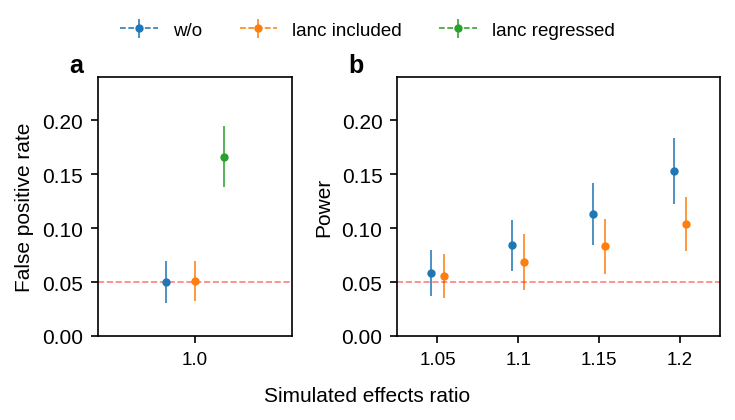

In [22]:
hsq = 0.006

fig, axes = plt.subplots(
    figsize=(5, 2.4), ncols=2, gridspec_kw={"width_ratios": [1.8, 3]}, dpi=150
)

# heterogeneity statistics
for method_i in range(3):
    tmp_mean = df_het_mean.loc[hsq, f"m{method_i + 1}"]
    tmp_sem = df_het_se.loc[hsq, f"m{method_i + 1}"]
    # false positives
    axes[0].errorbar(
        x=(method_i - 1) * 0.15,
        y=tmp_mean.iloc[0],
        yerr=tmp_sem.iloc[0] * 1.96,
        fmt=".--",
        lw=0.75,
        label=dict_method[f"m{method_i + 1}"],
    )

    if method_i != 2:
        # power
        axes[1].errorbar(
            x=np.arange(len(tmp_mean.iloc[1:])) + (method_i - 0.5) * 0.15,
            y=tmp_mean.iloc[1:],
            yerr=tmp_sem.iloc[1:] * 1.96,
            fmt=".",
            lw=0.75,
            label=dict_method[f"m{method_i + 1}"],
        )


# false positives
axes[0].set_xticks([0])
axes[0].set_xticklabels([1.0], fontsize=9)
axes[0].set_ylim(0, 0.24)
axes[0].set_xlim(-0.5, 0.5)
axes[0].axhline(y=0.05, ls="--", color="red", alpha=0.5, lw=0.8)
axes[0].set_ylabel("False positive rate")

# power
axes[1].set_xticks(np.arange(len(tmp_mean) - 1))
axes[1].set_xlim(-0.5, len(tmp_mean) - 1.5)

axes[1].set_xticklabels(tmp_mean.index[1:], fontsize=9)
axes[1].set_ylim(0, 0.24)
axes[1].axhline(y=0.05, ls="--", color="red", alpha=0.5, lw=0.8)
axes[1].set_ylabel("Power")

# # deming regression
# # heterogeneity statistics
# for method_i in range(3):
#     tmp_mean = df_deming_mean.loc[hsq, f"m{method_i + 1}"]
#     tmp_sem = df_deming_se.loc[hsq, f"m{method_i + 1}"]
#     # heterogeneity statistics
#     axes[1].errorbar(
#         x=np.arange(len(tmp_mean)) + (method_i - 1) * 0.15,
#         y=tmp_mean,
#         yerr=tmp_sem * 1.96,
#         fmt=".--",
#         lw=0.75,
#         label=f"{method_i}",
#     )

# for i_ratio, ratio in enumerate([0.9, 0.95, 1.0, 1.05, 1.1]):
#     axes[1].hlines(
#         y=ratio,
#         xmin=i_ratio - 0.5,
#         xmax=i_ratio + 0.5,
#         color="black",
#         ls="--",
#         lw=0.8,
#     )

# # x-axis
# axes[1].set_xticks(np.arange(len(tmp_mean)))
# axes[1].set_xticklabels(tmp_mean.index, fontsize=9)

# # y-axis
# axes[1].set_xlim(-0.5, 4.5)
# axes[1].set_ylim(0.85, 1.15)
# axes[1].axhline(y=1.0, ls="--", color="red", alpha=0.5, lw=0.8)
# axes[1].set_ylabel("Deming slope")
# axes[1].plot([-1, 5], [0.85, 1.15], color="k", ls="--", lw=0.8, alpha=0.5)
# axes[1].set_yticks([0.9, 1.0, 1.1])

for i, ax in enumerate(axes):
    ax.text(
        -0.15,
        1.02,
        string.ascii_lowercase[i],
        transform=ax.transAxes,
        size=12,
        weight="bold",
    )

# # trick to put title in the same row
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    ncol=3,
    loc="center",
    bbox_to_anchor=[0.5, 1.0],
    frameon=False,
    fontsize=9,
)

fig.text(
    0.5,
    -0.03,
    "Simulated effects ratio",
    fontsize=10,
    ha="center",
)
fig.tight_layout()
fig.savefig("results/lanc-pitfall.pdf", bbox_inches="tight")

# Legacy code (todo: move to supp. figures)

In [58]:
assert False

AssertionError: 

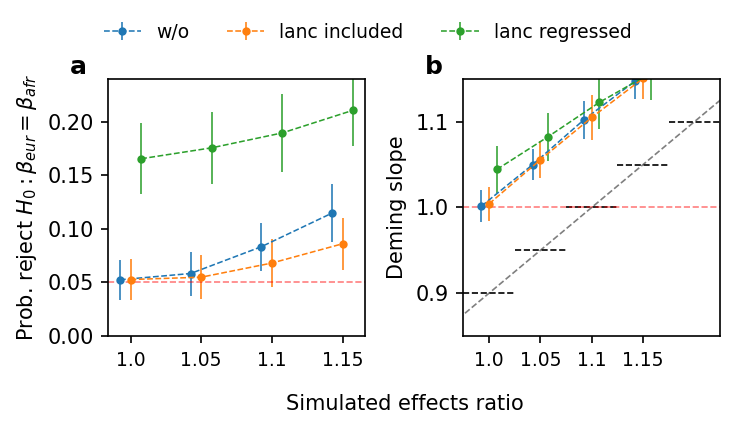

In [39]:
hsq = 0.006

fig, axes = plt.subplots(figsize=(5, 2.4), ncols=2, dpi=150)

# heterogeneity statistics
for method_i in range(3):
    tmp_mean = df_het_mean.loc[hsq, f"m{method_i + 1}"]
    tmp_sem = df_het_se.loc[hsq, f"m{method_i + 1}"]
    # heterogeneity statistics
    axes[0].errorbar(
        x=np.arange(len(tmp_mean)) + (method_i - 1) * 0.15,
        y=tmp_mean,
        yerr=tmp_sem * 1.96,
        fmt=".--",
        lw=0.75,
        label=dict_method[f"m{method_i + 1}"],
    )

# x-axis
axes[0].set_xticks(np.arange(len(tmp_mean)))
axes[0].set_xticklabels(tmp_mean.index, fontsize=9)

# y-axis
axes[0].set_ylim(0, 0.24)
axes[0].axhline(y=0.05, ls="--", color="red", alpha=0.5, lw=0.8)
axes[0].set_ylabel(r"Prob. reject $H_0: \beta_{eur}=\beta_{afr}$")

# deming regression
# heterogeneity statistics
for method_i in range(3):
    tmp_mean = df_deming_mean.loc[hsq, f"m{method_i + 1}"]
    tmp_sem = df_deming_se.loc[hsq, f"m{method_i + 1}"]
    # heterogeneity statistics
    axes[1].errorbar(
        x=np.arange(len(tmp_mean)) + (method_i - 1) * 0.15,
        y=tmp_mean,
        yerr=tmp_sem * 1.96,
        fmt=".--",
        lw=0.75,
        label=f"{method_i}",
    )

for i_ratio, ratio in enumerate([0.9, 0.95, 1.0, 1.05, 1.1]):
    axes[1].hlines(
        y=ratio,
        xmin=i_ratio - 0.5,
        xmax=i_ratio + 0.5,
        color="black",
        ls="--",
        lw=0.8,
    )

# x-axis
axes[1].set_xticks(np.arange(len(tmp_mean)))
axes[1].set_xticklabels(tmp_mean.index, fontsize=9)

# y-axis
axes[1].set_xlim(-0.5, 4.5)
axes[1].set_ylim(0.85, 1.15)
axes[1].axhline(y=1.0, ls="--", color="red", alpha=0.5, lw=0.8)
axes[1].set_ylabel("Deming slope")
axes[1].plot([-1, 5], [0.85, 1.15], color="k", ls="--", lw=0.8, alpha=0.5)
axes[1].set_yticks([0.9, 1.0, 1.1])

for i, ax in enumerate(axes):
    ax.text(
        -0.15,
        1.02,
        string.ascii_lowercase[i],
        transform=ax.transAxes,
        size=12,
        weight="bold",
    )

# trick to put title in the same row
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    ncol=3,
    loc="center",
    bbox_to_anchor=[0.5, 1.0],
    frameon=False,
    fontsize=9,
)

fig.text(
    0.55,
    -0.05,
    "Simulated effects ratio",
    fontsize=10,
    ha="center",
)
fig.tight_layout()
fig.savefig("results/lanc-pitfall.pdf", bbox_inches="tight")

# High correlation of effect count

In [10]:
from scipy.stats import pearsonr

2022-03-17 21:07.50 [info     ] admix.Dataset: read local ancestry from /u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01-dataset/out/aframr/hm3/chr1.lanc


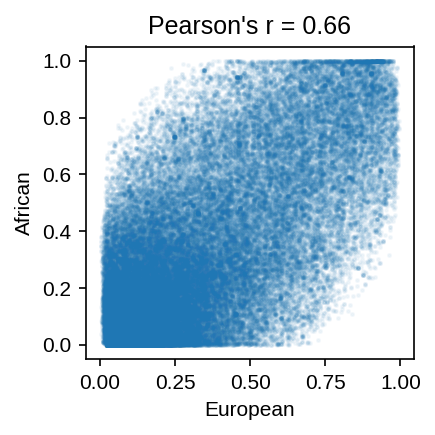

In [11]:
pfile = "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01-dataset/out/aframr/hm3/chr1"
dset = admix.io.read_dataset(pfile=pfile, n_anc=2, snp_chunk=128)

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(dset.snp.EUR_FREQ, dset.snp.AFR_FREQ, s=2, alpha=0.05)
ax.set_xlabel("European")
ax.set_ylabel("African")
ax.set_title(f"Pearson's r = {pearsonr(dset.snp.EUR_FREQ, dset.snp.AFR_FREQ)[0]:.2f}")
fig.tight_layout()
fig.savefig("results/admix-freq.png", bbox_inches="tight")

In [12]:
dset_subset = dset[
    (
        dset.snp.EUR_FREQ.between(0.01, 0.99) & dset.snp.AFR_FREQ.between(0.01, 0.99)
    ).values
]
dset_subset = dset_subset[np.linspace(0, dset_subset.n_snp - 1, 500).astype(int)]
apa = dset_subset.allele_per_anc().compute()
lanc = dset_subset.lanc.sum(axis=2).compute()

In [13]:
np.random.seed(1234)

df_corr_list = []
for snp_i in tqdm(range(apa.shape[0])):
    apa_snp = apa[snp_i, :, :]
    lanc_snp = lanc[snp_i, :]

    df_corr = pd.DataFrame(
        np.column_stack([apa_snp, lanc_snp]), columns=["EUR", "AFR", "lanc"]
    ).corr()
    df_corr_list.append(df_corr)

avg_df_corr = np.zeros_like(df_corr_list[0])
for d in df_corr_list:
    avg_df_corr += d
avg_df_corr /= len(df_corr_list)

100%|██████████| 500/500 [00:00<00:00, 974.12it/s]


In [14]:
corr_mean = pd.DataFrame(
    np.mean(df_corr_list, axis=0),
    index=df_corr_list[0].index,
    columns=df_corr_list[0].columns,
)
corr_sem = pd.DataFrame(
    np.std(df_corr_list, axis=0) / np.sqrt(len(df_corr_list)),
    index=df_corr_list[0].index,
    columns=df_corr_list[0].columns,
)

In [15]:
df_corr = pd.DataFrame(index=corr_mean.index, columns=corr_mean.columns)
for i in corr_mean.index:
    for j in corr_mean.columns:
        df_corr.loc[i, j] = f"{corr_mean.loc[i, j]:.2f}"
        if i != j:
            df_corr.loc[i, j] += f" $\pm$ {corr_sem.loc[i, j]:.2g}"

In [16]:
print(df_corr.to_latex(escape=False))

\begin{tabular}{llll}
\toprule
{} &                 EUR &                 AFR &                lanc \\
\midrule
EUR  &                1.00 &  -0.22 $\pm$ 0.0086 &  -0.55 $\pm$ 0.0098 \\
AFR  &  -0.22 $\pm$ 0.0086 &                1.00 &   0.36 $\pm$ 0.0092 \\
lanc &  -0.55 $\pm$ 0.0098 &   0.36 $\pm$ 0.0092 &                1.00 \\
\bottomrule
\end{tabular}

